[OK] ZIP already exists: hospital_week7_work\Hospital_Revised_Flatfiles.zip
[OK] Already extracted: hospital_week7_work\extracted
[INFO] Tabular files found: 67
  - Ambulatory Surgical Measures-Facility.csv
  - Ambulatory Surgical Measures-National.csv
  - Ambulatory Surgical Measures-State.csv
  - Complications and Deaths - Hospital.csv
  - Complications and Deaths - National.csv
  - Complications and Deaths - State.csv
  - FINAL CJR Quality PR - PY1 File Values_Updated.csv
  - Footnote Crosswalk.csv
  - FY2015_Distribution_of_Net_Change_in_Base_Op_DRG_Payment_Amt.csv
  - FY2015_Net_Change_in_Base_Op_DRG_Payment_Amt.csv
[INFO] Loading file: Ambulatory Surgical Measures-Facility.csv (delimiter=',')
[OK] Loaded shape: (5291, 46)
[INFO] Dropping ID-like columns: ['Provider_ID', 'ASC_1_5_Encounter_Start_Date', 'ASC_1_5_Encounter_End_Date', 'ASC_6_7_Encounter_Start_Date', 'ASC_6_7_Encounter_End_Date', 'ASC_8_Encounter_Date', 'ASC_9_10_Encounter_Start_Date', 'ASC_9_10_Encounter_End_Date', '

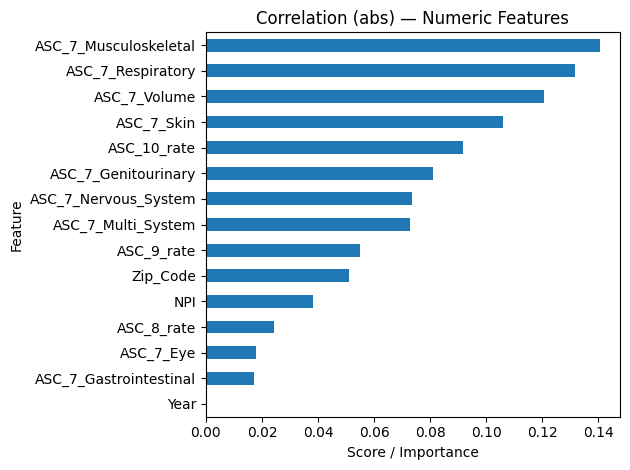


=== Ranked List: Chi-square — One-hot Categorical vs Target (Top 15) ===
 1. ASC_2_Footnote_N/A (1)                         267.000000
 2. ASC_3_Footnote_N/A (1)                         267.000000
 3. ASC_4_Footnote_N/A (1)                         267.000000
 4. ASC_3_Footnote_N/A (5)                         109.000000
 5. ASC_2_Footnote_N/A (5)                         109.000000
 6. ASC_4_Footnote_N/A (5)                         109.000000
 7. ASC_5_Footnote_N/A (1)                         100.431193
 8. ASC_5_Footnote_N/A (5)                         12.291579
 9. City_Greenbrae                                 4.899083
10. City_Dalton                                    4.899083
11. City_Beltsville                                4.899083
12. State_MD                                       4.480648
13. City_Plano                                     4.113528
14. City_Westminster                               2.449541
15. City_Wenatchee                                 2.449541


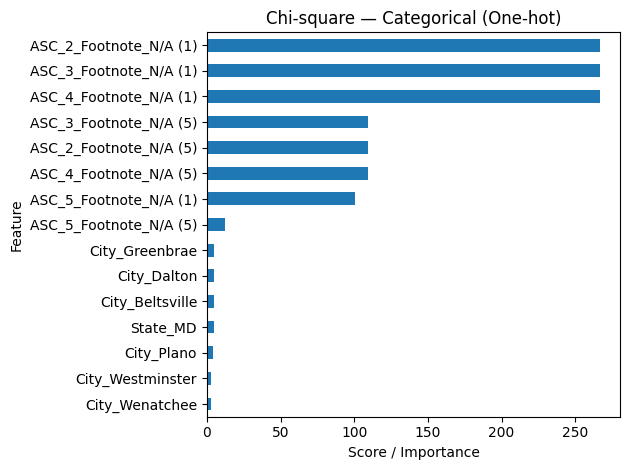


=== Ranked List: Mutual Information — All Features (after preprocessing) (Top 15) ===
 1. num__NPI                                       0.602056
 2. cat__ASC_3_Footnote_N/A (1)                    0.602056
 3. cat__ASC_2_Footnote_N/A (5)                    0.602056
 4. cat__ASC_3_Footnote_N/A (5)                    0.602056
 5. cat__ASC_2_Footnote_N/A (1)                    0.602056
 6. cat__ASC_4_Footnote_N/A (5)                    0.602056
 7. cat__ASC_4_Footnote_N/A (1)                    0.602056
 8. num__Zip_Code                                  0.525718
 9. cat__ASC_5_Footnote_N/A (5)                    0.152557
10. cat__ASC_5_Footnote_N/A (1)                    0.152557
11. num__ASC_7_Volume                              0.130612
12. num__ASC_8_rate                                0.119484
13. num__ASC_7_Musculoskeletal                     0.062239
14. num__ASC_7_Gastrointestinal                    0.043161
15. num__ASC_7_Skin                                0.042687


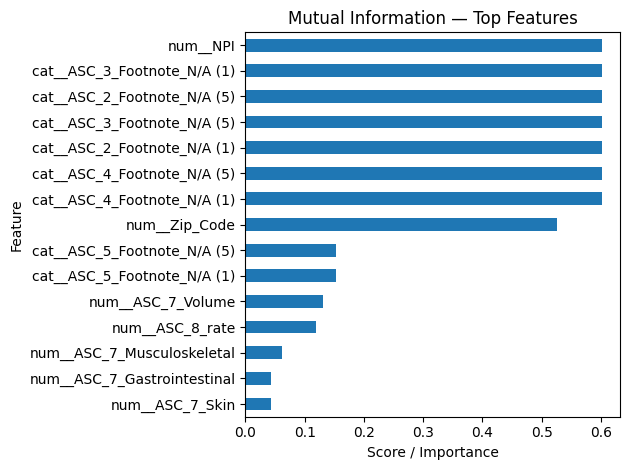

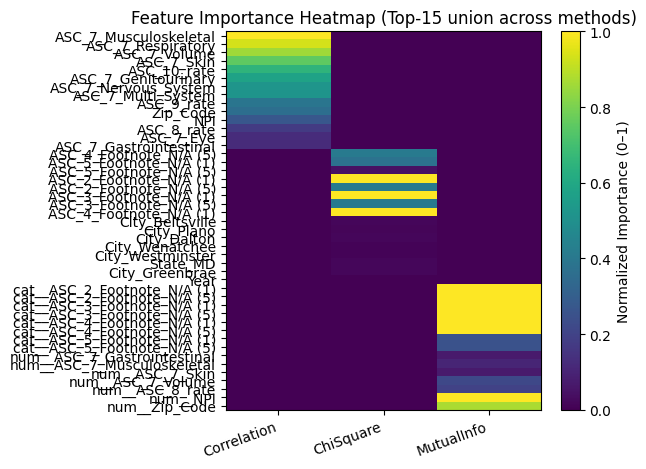


================= LESSON 4 EVALUATION =================
Baseline Model (ALL features after preprocessing)
Features used     : 725
Training time (s) : 0.0850
Accuracy          : 1.0000
AUC               : 1.0000

Selected-Feature Model (Top-K by Mutual Information)
Features used     : 20
Training time (s) : 0.0065
Accuracy          : 1.0000
AUC               : 1.0000

Trade-off Summary
- Feature reduction: 705 fewer features
- Time change      : 0.0850s → 0.0065s


In [7]:
"""
WEEK 7 — Feature Selection (I): Filter Methods — End-to-End Program
Dataset: Hospital_Revised_Flatfiles.zip (GitHub)

This script performs everything discussed in Week 7:
1) Load ZIP dataset (download + unzip)
2) Identify a tabular flat file inside (CSV/TXT)
3) Select target column (auto-detect + optional manual override)
4) Preprocess (impute + one-hot encode categoricals)
5) FILTER METHODS:
   - Correlation (Pearson) for numeric
   - Chi-square for categorical (after one-hot; requires non-negative inputs)
   - Mutual Information (general dependency)
   - Fisher Score (for binary classification)
6) Visualizations:
   - Bar chart (Top-N)
   - Ranked list (Top-N)
   - Heatmap (compare importance across methods)
7) Practical evaluation (Lesson 4):
   - Baseline model using ALL features
   - Same model using SELECTED features
   - Compare Accuracy/AUC + training time + feature count
"""

import os
import re
import time
import zipfile
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")


# =========================================================
# 0) CONFIG
# =========================================================
ZIP_URL = "https://github.com/swapnilsaurav/Dataset/raw/master/Hospital_Revised_Flatfiles.zip"
WORKDIR = Path("hospital_week7_work")
WORKDIR.mkdir(parents=True, exist_ok=True)

ZIP_PATH = WORKDIR / "Hospital_Revised_Flatfiles.zip"
EXTRACT_DIR = WORKDIR / "extracted"

# If auto-detection fails, set this manually:
# Example: TARGET_COL = "Readmitted" or "Outcome" etc.
TARGET_COL = None  # <-- change if needed

TOP_N = 15  # for plots/ranked list
RANDOM_STATE = 42


# =========================================================
# 1) DOWNLOAD ZIP (works in local Jupyter/Colab)
# =========================================================
def download_zip(url: str, out_path: Path) -> None:
    if out_path.exists():
        print(f"[OK] ZIP already exists: {out_path}")
        return

    print("[INFO] Downloading ZIP...")
    try:
        import requests
    except ImportError:
        raise RuntimeError("Please install requests: pip install requests")

    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)
    print(f"[OK] Downloaded: {out_path}")


def unzip(zip_path: Path, out_dir: Path) -> None:
    if out_dir.exists() and any(out_dir.rglob("*")):
        print(f"[OK] Already extracted: {out_dir}")
        return

    out_dir.mkdir(parents=True, exist_ok=True)
    print("[INFO] Extracting ZIP...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(out_dir)
    print(f"[OK] Extracted to: {out_dir}")


# =========================================================
# 2) FIND A TABULAR FILE INSIDE ZIP
# =========================================================
def find_tabular_files(root: Path):
    exts = {".csv", ".txt", ".tsv"}
    files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            files.append(p)
    return sorted(files)


def sniff_delimiter(file_path: Path) -> str:
    # quick heuristic: if tabs appear frequently -> tsv else comma
    sample = file_path.read_text(errors="ignore")[:5000]
    if sample.count("\t") > sample.count(","):
        return "\t"
    return ","


def load_first_tabular(files):
    # Prefer CSV, then TSV/TXT
    if not files:
        raise FileNotFoundError("No CSV/TXT/TSV file found inside the ZIP.")

    chosen = files[0]
    delim = sniff_delimiter(chosen)
    print(f"[INFO] Loading file: {chosen.name} (delimiter='{delim}')")

    df = pd.read_csv(chosen, delimiter=delim, encoding="latin1", low_memory=False)
    print(f"[OK] Loaded shape: {df.shape}")
    return df, chosen


# =========================================================
# 3) TARGET COLUMN AUTO-DETECTION
# =========================================================
def auto_pick_target(df: pd.DataFrame) -> str:
    """
    Try to detect a likely classification target column.
    Priority:
    - common names: target, label, outcome, y, class, readmit, mortality, etc.
    - binary-like columns (2 unique values) excluding ID-like fields
    """
    cols = [c for c in df.columns]
    lowered = {c: str(c).lower() for c in cols}

    # Name-based candidates
    name_patterns = [
        "target", "label", "outcome", "class", r"\by\b",
        "readmit", "readmitted", "mortality", "death", "diagnosis", "disease"
    ]
    for pat in name_patterns:
        for c in cols:
            if re.search(pat, lowered[c]):
                return c

    # Binary-like candidates
    binary_candidates = []
    for c in cols:
        s = df[c]
        nunique = s.dropna().nunique()
        if nunique == 2:
            # exclude IDs (often numeric with many uniques, but just in case)
            if "id" in lowered[c] or "patient" in lowered[c]:
                continue
            binary_candidates.append(c)

    if binary_candidates:
        return binary_candidates[0]

    # Fallback: last column
    return cols[-1]


# =========================================================
# 4) BASIC CLEANUP + TYPE INFERENCE
# =========================================================
def drop_id_like_cols(df: pd.DataFrame) -> pd.DataFrame:
    id_like = []
    for c in df.columns:
        lc = str(c).lower()
        if any(k in lc for k in ["id", "patient_id", "encounter", "mrn"]):
            id_like.append(c)
    if id_like:
        print(f"[INFO] Dropping ID-like columns: {id_like}")
        return df.drop(columns=id_like)
    return df


def coerce_binary_target(y: pd.Series) -> pd.Series:
    """
    Ensure y is binary 0/1 if possible.
    If y is strings like 'Yes'/'No', map to 1/0.
    If y has 2 unique values, map them to 0/1.
    """
    y_clean = y.copy()

    # If already numeric and binary
    uniq = pd.unique(y_clean.dropna())
    if len(uniq) == 2:
        if pd.api.types.is_numeric_dtype(y_clean):
            # map to 0/1 if values aren't already
            sorted_vals = sorted(list(uniq))
            mapping = {sorted_vals[0]: 0, sorted_vals[1]: 1}
            return y_clean.map(mapping).astype(int)

        # string/object binary
        mapping = {uniq[0]: 0, uniq[1]: 1}
        return y_clean.map(mapping).astype(int)

    # If not binary, keep as-is (still works for MI; Fisher will be skipped)
    return y_clean


# =========================================================
# 5) FILTER METHODS
# =========================================================
def fisher_score_binary(X_num: pd.DataFrame, y_bin: pd.Series) -> pd.Series:
    """
    Fisher Score for each numeric feature (binary classification).
    F = (mu1 - mu0)^2 / (var1 + var0 + eps)
    """
    eps = 1e-12
    yv = y_bin.values
    mask1 = yv == 1
    mask0 = yv == 0

    scores = {}
    for col in X_num.columns:
        a = X_num[col].astype(float)
        a0 = a[mask0]
        a1 = a[mask1]

        mu0, mu1 = a0.mean(), a1.mean()
        v0, v1 = a0.var(ddof=1), a1.var(ddof=1)
        scores[col] = ((mu1 - mu0) ** 2) / (v0 + v1 + eps)

    return pd.Series(scores).sort_values(ascending=False)


# =========================================================
# 6) VISUALIZATION HELPERS
# =========================================================
def plot_top_bar(scores: pd.Series, title: str, top_n: int = 15):
    s = scores.sort_values(ascending=False).head(top_n)[::-1]
    plt.figure()
    s.plot(kind="barh")
    plt.title(title)
    plt.xlabel("Score / Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


def print_ranked_list(scores: pd.Series, title: str, top_n: int = 15):
    print(f"\n=== Ranked List: {title} (Top {top_n}) ===")
    top = scores.sort_values(ascending=False).head(top_n)
    for i, (feat, val) in enumerate(top.items(), start=1):
        print(f"{i:2d}. {feat:45s}  {val:.6f}")


def plot_heatmap(score_df: pd.DataFrame, title: str):
    # Normalize per column for fair comparison in heatmap
    norm = score_df.copy()
    for c in norm.columns:
        col = norm[c].astype(float)
        if col.max() > 0:
            norm[c] = col / col.max()
        else:
            norm[c] = col

    plt.figure()
    plt.imshow(norm.values, aspect="auto")
    plt.title(title)
    plt.yticks(range(norm.shape[0]), norm.index)
    plt.xticks(range(norm.shape[1]), norm.columns, rotation=20, ha="right")
    plt.colorbar(label="Normalized Importance (0–1)")
    plt.tight_layout()
    plt.show()


# =========================================================
# 7) MODEL EVALUATION: BASELINE vs SELECTED
# =========================================================
def build_preprocessor(numeric_cols, categorical_cols):
    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                # MinMaxScaler ensures non-negative values (helpful for chi2 if needed later)
                ("scaler", MinMaxScaler())
            ]), numeric_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols),
        ],
        remainder="drop"
    )


def eval_model_all_vs_selected(X_train, X_test, y_train, y_test,
                               numeric_cols, categorical_cols,
                               selected_feature_names_after_ohe=None):
    """
    Baseline: LogisticRegression with all preprocessed features
    Selected: LogisticRegression with only selected *post-encoding* features
             (we select columns from transformed matrix using feature names)
    """
    # ---------------- Baseline ----------------
    pre = build_preprocessor(numeric_cols, categorical_cols)
    baseline = Pipeline([
        ("prep", pre),
        ("clf", LogisticRegression(max_iter=1000))
    ])

    t0 = time.time()
    baseline.fit(X_train, y_train)
    t_baseline = time.time() - t0

    proba_b = baseline.predict_proba(X_test)[:, 1] if hasattr(baseline, "predict_proba") else None
    pred_b = baseline.predict(X_test)

    acc_b = accuracy_score(y_test, pred_b)
    auc_b = roc_auc_score(y_test, proba_b) if proba_b is not None and len(pd.unique(y_test)) == 2 else np.nan

    # get number of final features (after one-hot)
    feature_names = baseline.named_steps["prep"].get_feature_names_out()
    n_all = len(feature_names)

    # ---------------- Selected (post-encoding) ----------------
    if not selected_feature_names_after_ohe:
        return {
            "baseline": (n_all, t_baseline, acc_b, auc_b),
            "selected": None,
            "feature_names_all": feature_names
        }

    # Transform train/test, then subset columns
    Xtr = baseline.named_steps["prep"].transform(X_train)
    Xte = baseline.named_steps["prep"].transform(X_test)

    # Map selected feature names to indices
    name_to_idx = {name: i for i, name in enumerate(feature_names)}
    idx = [name_to_idx[n] for n in selected_feature_names_after_ohe if n in name_to_idx]
    if not idx:
        raise ValueError("None of the selected features matched the transformed feature names.")

    Xtr_sel = Xtr[:, idx]
    Xte_sel = Xte[:, idx]

    clf2 = LogisticRegression(max_iter=1000)
    t0 = time.time()
    clf2.fit(Xtr_sel, y_train)
    t_sel = time.time() - t0

    proba_s = clf2.predict_proba(Xte_sel)[:, 1] if hasattr(clf2, "predict_proba") else None
    pred_s = clf2.predict(Xte_sel)

    acc_s = accuracy_score(y_test, pred_s)
    auc_s = roc_auc_score(y_test, proba_s) if proba_s is not None and len(pd.unique(y_test)) == 2 else np.nan

    return {
        "baseline": (n_all, t_baseline, acc_b, auc_b),
        "selected": (len(idx), t_sel, acc_s, auc_s),
        "feature_names_all": feature_names,
        "selected_indices": idx
    }


# =========================================================
# RUN EVERYTHING
# =========================================================
download_zip(ZIP_URL, ZIP_PATH)
unzip(ZIP_PATH, EXTRACT_DIR)

files = find_tabular_files(EXTRACT_DIR)
print(f"[INFO] Tabular files found: {len(files)}")
for f in files[:10]:
    print("  -", f.relative_to(EXTRACT_DIR))

df, chosen_file = load_first_tabular(files)
df = drop_id_like_cols(df)

# Target selection
if TARGET_COL is None:
    TARGET_COL = auto_pick_target(df)
print(f"[INFO] Using target column: {TARGET_COL}")

# Basic NA cleanup
df = df.dropna(axis=0, subset=[TARGET_COL]).copy()

X = df.drop(columns=[TARGET_COL])
y_raw = df[TARGET_COL]
y = coerce_binary_target(y_raw)

# Identify column types
numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print(f"[INFO] Numeric cols: {len(numeric_cols)} | Categorical cols: {len(categorical_cols)}")
print("[INFO] Sample numeric:", numeric_cols[:8])
print("[INFO] Sample categorical:", categorical_cols[:8])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE,
    stratify=y if len(pd.unique(y)) == 2 else None
)

# -----------------------------
# FILTER 1: Correlation (numeric only)
# -----------------------------
corr_scores = None
if numeric_cols:
    corr_df = pd.concat([X_train[numeric_cols], pd.Series(y_train, name="__target__")], axis=1)
    corr_scores = corr_df.corr(numeric_only=True)["__target__"].drop("__target__", errors="ignore").abs().sort_values(ascending=False)
    print_ranked_list(corr_scores, "Correlation (abs) — Numeric vs Target", top_n=TOP_N)
    plot_top_bar(corr_scores, "Correlation (abs) — Numeric Features", top_n=TOP_N)

# -----------------------------
# FILTER 2: Chi-square (categorical after one-hot, non-negative)
# -----------------------------
chi_scores = None
if categorical_cols:
    # One-hot categorical (impute missing)
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    X_train_cat = cat_pipe.fit_transform(X_train[categorical_cols])
    cat_names = cat_pipe.named_steps["ohe"].get_feature_names_out(categorical_cols)

    # Chi2 expects non-negative. One-hot is 0/1 => OK.
    chi_vals, chi_p = chi2(X_train_cat, y_train)
    chi_scores = pd.Series(chi_vals, index=cat_names).sort_values(ascending=False)

    print_ranked_list(chi_scores, "Chi-square — One-hot Categorical vs Target", top_n=TOP_N)
    plot_top_bar(chi_scores, "Chi-square — Categorical (One-hot)", top_n=TOP_N)

# -----------------------------
# FILTER 3: Mutual Information (all features after preprocessing)
# -----------------------------
# Build full preprocessing to get a single design matrix
pre_all = build_preprocessor(numeric_cols, categorical_cols)
Xtr_all = pre_all.fit_transform(X_train, y_train)
feat_names_all = pre_all.get_feature_names_out()

mi_vals = mutual_info_classif(Xtr_all, y_train, random_state=RANDOM_STATE)
mi_scores = pd.Series(mi_vals, index=feat_names_all).sort_values(ascending=False)

print_ranked_list(mi_scores, "Mutual Information — All Features (after preprocessing)", top_n=TOP_N)
plot_top_bar(mi_scores, "Mutual Information — Top Features", top_n=TOP_N)

#####
# -----------------------------
# HEATMAP: Compare importance across methods (Top-N union)
# -----------------------------
score_frames = []
if corr_scores is not None:
    score_frames.append(corr_scores.rename("Correlation"))
if chi_scores is not None:
    score_frames.append(chi_scores.rename("ChiSquare"))
score_frames.append(mi_scores.rename("MutualInfo"))
if fisher_scores is not None:
    score_frames.append(fisher_scores.rename("Fisher"))

# Align to common index: take union of top-N from each method
top_union = set()
for s in score_frames:
    top_union.update(s.head(TOP_N).index.tolist())

compare_df = pd.concat([s.reindex(sorted(top_union)).fillna(0) for s in score_frames], axis=1)
compare_df = compare_df.sort_values(by=compare_df.columns[0], ascending=False)

plot_heatmap(compare_df, f"Feature Importance Heatmap (Top-{TOP_N} union across methods)")

# -----------------------------
# LESSON 4 EVALUATION: Baseline vs Selected
# Choose selected features using MI Top-K (post-encoding names)
# -----------------------------
K = min(20, len(mi_scores))
selected_after_ohe = mi_scores.head(K).index.tolist()

results = eval_model_all_vs_selected(
    X_train, X_test, y_train, y_test,
    numeric_cols, categorical_cols,
    selected_feature_names_after_ohe=selected_after_ohe
)

n_all, t_all, acc_all, auc_all = results["baseline"]
print("\n================= LESSON 4 EVALUATION =================")
print("Baseline Model (ALL features after preprocessing)")
print(f"Features used     : {n_all}")
print(f"Training time (s) : {t_all:.4f}")
print(f"Accuracy          : {acc_all:.4f}")
print(f"AUC               : {auc_all:.4f}")

if results["selected"] is not None:
    n_sel, t_sel, acc_sel, auc_sel = results["selected"]
    print("\nSelected-Feature Model (Top-K by Mutual Information)")
    print(f"Features used     : {n_sel}")
    print(f"Training time (s) : {t_sel:.4f}")
    print(f"Accuracy          : {acc_sel:.4f}")
    print(f"AUC               : {auc_sel:.4f}")

    print("\nTrade-off Summary")
    print(f"- Feature reduction: {n_all - n_sel} fewer features")
    print(f"- Time change      : {t_all:.4f}s → {t_sel:.4f}s")
    print("=======================================================")
else:
    print("\n[WARN] Selected-model comparison skipped (selection mapping failed).")
    print("=======================================================")
